In [9]:
# !pip install tensorflow
# !pip install torch torchvision

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms 
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.metrics import f1_score, confusion_matrix  
from collections import defaultdict 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

In [3]:
selected_classes = [0, 1, 2]

def filter_classes(dataset, selected_classes): 
    indices = [i for i, (_, label) in enumerate(dataset) if label in selected_classes]
    filtered_data = torch.utils.data.Subset(dataset, indices)
    return filtered_data

def stratified_split(dataset): 
    targets = [dataset[i][1] for i in range(len(dataset))]  
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(split.split(dataset, targets))
    train_split = torch.utils.data.Subset(dataset, train_idx)
    val_split = torch.utils.data.Subset(dataset, val_idx)
    
    return train_split, val_split

In [4]:
class myDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset 
        self.transform = transform 
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label


transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))    
])
 
cifar10_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_data_filtered = filter_classes(cifar10_train, selected_classes)
test_data_filtered = filter_classes(cifar10_test, selected_classes)
 
train_data, val_data = stratified_split(train_data_filtered)

train_dataset = myDataset(train_data, transform )
val_dataset = myDataset(val_data, transform )
test_dataset = myDataset(test_data_filtered, transform )

batch_size = 64 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Dataset: {len(train_dataset)} images")
print(f"Validation Dataset: {len(val_dataset)} images")
print(f"Test Dataset: {len(test_dataset)} images")

100%|██████████| 170M/170M [00:39<00:00, 4.28MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Dataset: 12000 images
Validation Dataset: 3000 images
Test Dataset: 3000 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

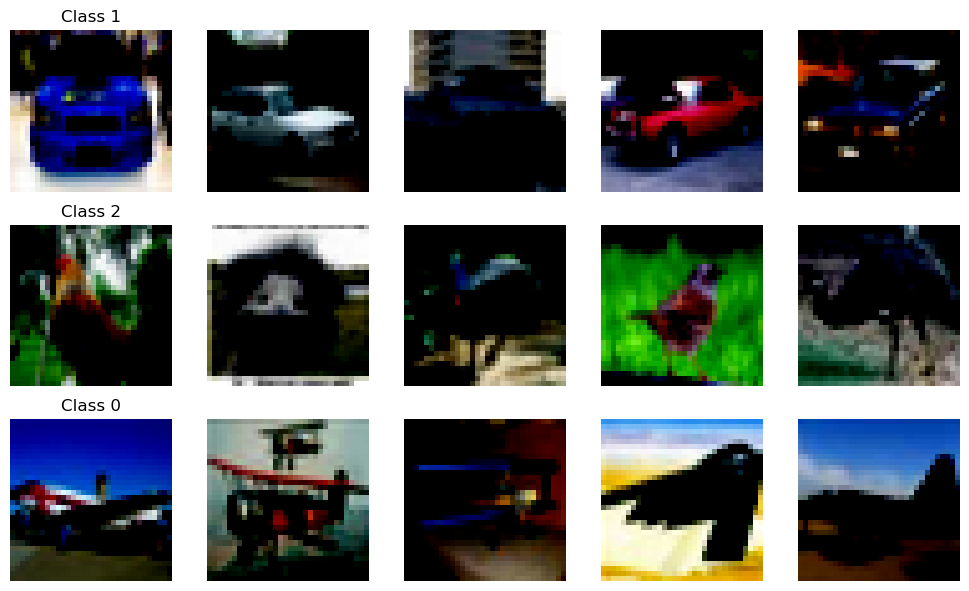

In [13]:
def visualize_images(dataset, num_images_per_class=5): 
    images_per_class = defaultdict(list)
    for image, label in dataset:
        if len(images_per_class[label]) < num_images_per_class:
            images_per_class[label].append(image)
        if all(len(images) >= num_images_per_class for images in images_per_class.values()):
            break

    num_classes = len(images_per_class)
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class * 2, num_classes * 2))
    
    for i, (label, images) in enumerate(images_per_class.items()):
        for j, image in enumerate(images):
            ax = axes[i, j] if num_classes > 1 else axes[j]
            ax.imshow(image.permute(1, 2, 0))   
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Class {label}")
    
    plt.tight_layout()
    plt.show()

visualize_images(train_dataset, num_images_per_class=5)

In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):  
        super(CNN, self).__init__()
         
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3) 
        self.fc1 = nn.Linear(32 * 2 * 8, 16) 
        self.fc2 = nn.Linear(16, num_classes)  
        self.relu = nn.ReLU()

    def forward(self, x): 
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 32 * 2 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model = CNN()  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 15

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
 
def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    train_accuracy = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)
 
    train_loss = running_loss / len(train_loader)
    train_accuracy = train_accuracy / len(train_loader)
 
    # model.eval() 
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad(): 
        for inputs, labels in val_loader: 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)
 
    val_loss = val_loss / len(val_loader)
    val_accuracy = val_accuracy / len(val_loader)
 
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
 
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy*100:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")

 
model_path = 'cnn_model.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")
 

Epoch [1/15]
Training Loss: 0.7060, Training Accuracy: 70.23%
Validation Loss: 0.5664, Validation Accuracy: 77.38%
Epoch [2/15]
Training Loss: 0.5102, Training Accuracy: 79.89%
Validation Loss: 0.4862, Validation Accuracy: 81.02%
Epoch [3/15]
Training Loss: 0.4532, Training Accuracy: 82.01%
Validation Loss: 0.4432, Validation Accuracy: 82.03%
Epoch [4/15]
Training Loss: 0.4096, Training Accuracy: 84.10%
Validation Loss: 0.4448, Validation Accuracy: 82.81%
Epoch [5/15]
Training Loss: 0.3738, Training Accuracy: 85.64%
Validation Loss: 0.3775, Validation Accuracy: 84.56%
Epoch [6/15]
Training Loss: 0.3507, Training Accuracy: 86.48%
Validation Loss: 0.3675, Validation Accuracy: 86.24%
Epoch [7/15]
Training Loss: 0.3376, Training Accuracy: 86.90%
Validation Loss: 0.3962, Validation Accuracy: 84.58%
Epoch [8/15]
Training Loss: 0.3200, Training Accuracy: 87.37%
Validation Loss: 0.3435, Validation Accuracy: 86.89%
Epoch [9/15]
Training Loss: 0.2999, Training Accuracy: 88.42%
Validation Loss: 0

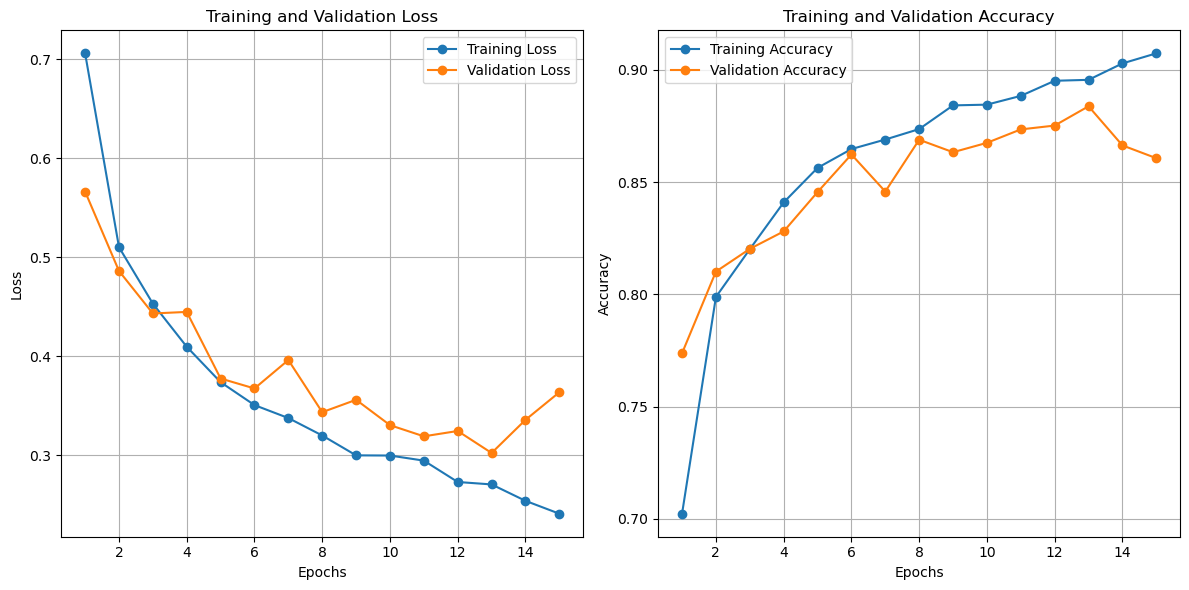

In [16]:
plt.figure(figsize=(12, 6))
 
plt.subplot(1, 2, 1) 
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
 
plt.subplot(1, 2, 2)  
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
 
plt.tight_layout()
plt.show()


In [17]:
def evaluate_model(model, test_loader):
    model.eval()
    test_accuracy = 0.0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_targets.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())
            
            test_accuracy += calculate_accuracy(outputs, labels)
    
    test_accuracy /= len(test_loader)
    f1 = f1_score(all_targets, all_predictions, average="weighted")
    
    return test_accuracy, f1, all_targets, all_predictions
 
test_accuracy, test_f1, test_targets, test_predictions = evaluate_model(model, test_loader)
train_accuracy, train_f1, train_targets, train_predictions = evaluate_model(model, train_loader)
val_accuracy, val_f1, val_targets, val_predictions = evaluate_model(model, val_loader)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"F1-Score: {test_f1:.4f}")

Test Accuracy: 87.04%
F1-Score: 0.8712


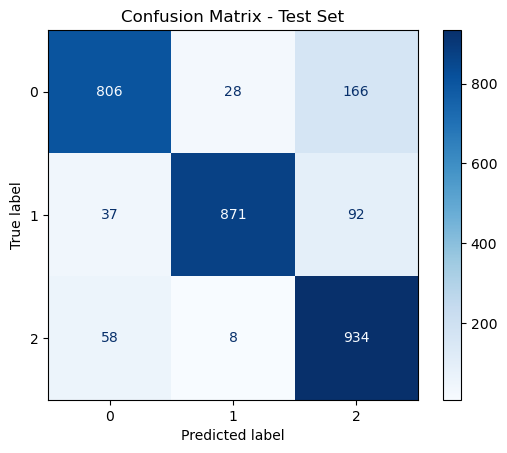

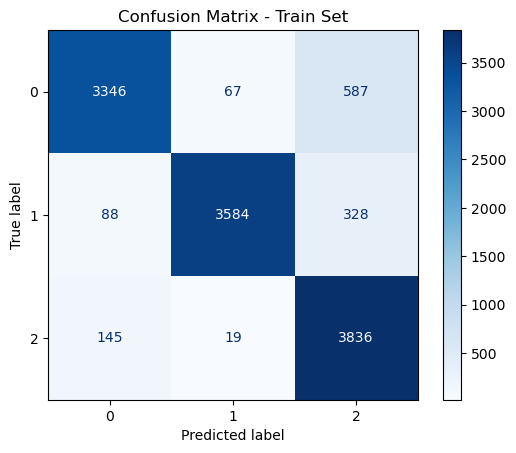

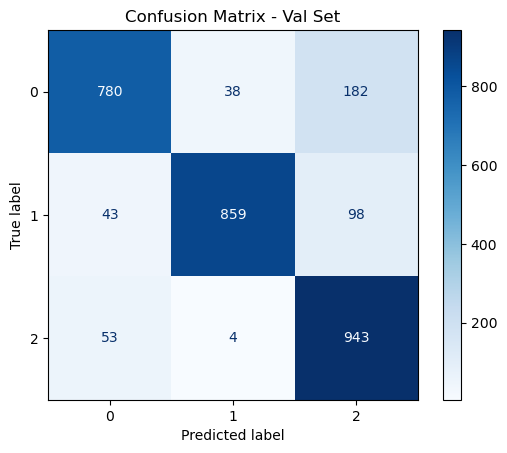

In [18]:
def plot_confusion_matrix(targets, predictions, title):
    cm = confusion_matrix(targets, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

plot_confusion_matrix(test_targets, test_predictions, "Confusion Matrix - Test Set")
plot_confusion_matrix(train_targets, train_predictions, "Confusion Matrix - Train Set")
plot_confusion_matrix(val_targets, val_predictions, "Confusion Matrix - Val Set") 

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) 
        self.relu = nn.ReLU() 
        self.fc2 = nn.Linear(64, num_classes) 

    def forward(self, x):
        x = self.fc1(x) 
        x = self.relu(x) 
        x = self.fc2(x) 
        return x
 
input_size = 32 * 32 * 3   
num_classes = 3 
num_epochs = 15
batch_size = 64
learning_rate = 0.001
 
model = MLP(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
 
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for inputs, labels in train_loader: 
        inputs = inputs.view(inputs.size(0), -1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
 
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_accuracy)

    # model.eval()   
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
 
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

torch.save(model.state_dict(), "mlp_model.pth")
print("Model saved as 'mlp_model.pth'")
 

Epoch [1/15]
Train Loss: 0.6958, Train Accuracy: 0.7177
Val Loss: 0.6218, Val Accuracy: 0.7500
Epoch [2/15]
Train Loss: 0.5625, Train Accuracy: 0.7788
Val Loss: 0.6058, Val Accuracy: 0.7573
Epoch [3/15]
Train Loss: 0.5078, Train Accuracy: 0.8032
Val Loss: 0.5953, Val Accuracy: 0.7690
Epoch [4/15]
Train Loss: 0.4663, Train Accuracy: 0.8195
Val Loss: 0.6075, Val Accuracy: 0.7630
Epoch [5/15]
Train Loss: 0.4304, Train Accuracy: 0.8281
Val Loss: 0.5885, Val Accuracy: 0.7753
Epoch [6/15]
Train Loss: 0.3998, Train Accuracy: 0.8499
Val Loss: 0.6035, Val Accuracy: 0.7753
Epoch [7/15]
Train Loss: 0.3759, Train Accuracy: 0.8558
Val Loss: 0.6309, Val Accuracy: 0.7783
Epoch [8/15]
Train Loss: 0.3406, Train Accuracy: 0.8722
Val Loss: 0.6431, Val Accuracy: 0.7610
Epoch [9/15]
Train Loss: 0.3198, Train Accuracy: 0.8818
Val Loss: 0.6002, Val Accuracy: 0.7790
Epoch [10/15]
Train Loss: 0.3000, Train Accuracy: 0.8892
Val Loss: 0.6450, Val Accuracy: 0.7753
Epoch [11/15]
Train Loss: 0.2773, Train Accuracy:

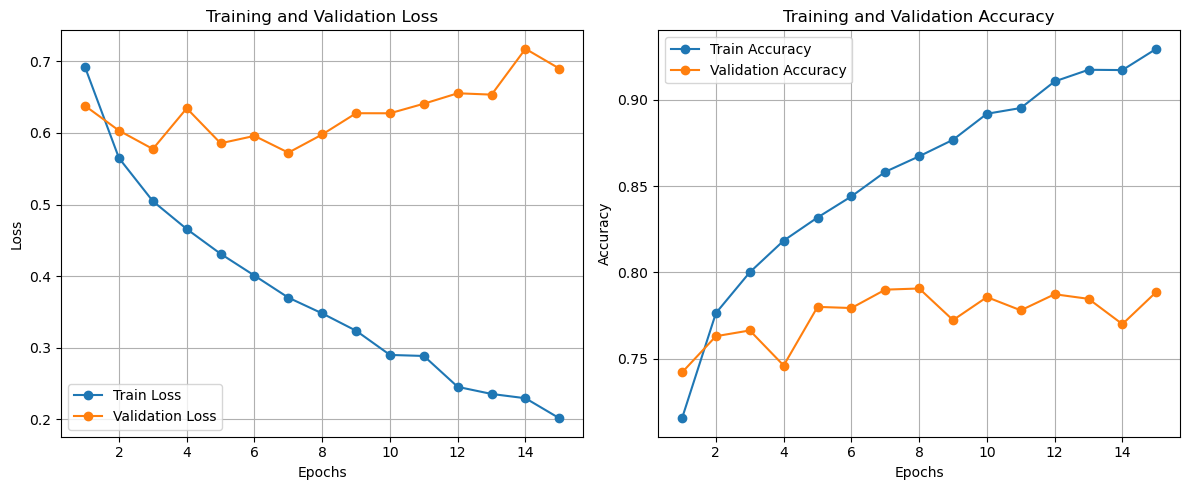

In [20]:
 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
axes[0].plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()
 
axes[1].plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
axes[1].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid() 
plt.tight_layout()
plt.show()


In [21]:
model.eval()

test_preds, test_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(inputs.size(0), -1)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}") 

Test Accuracy: 0.8073
Test F1-Score: 0.8073


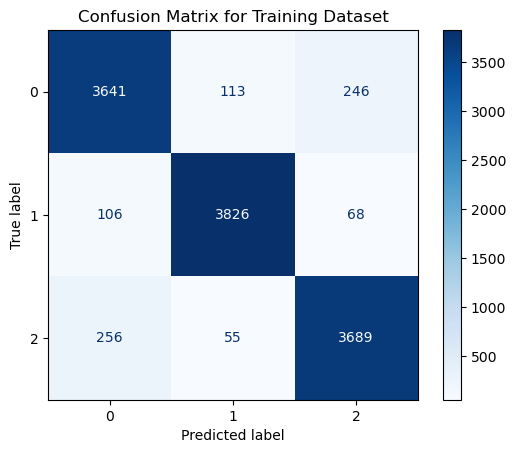

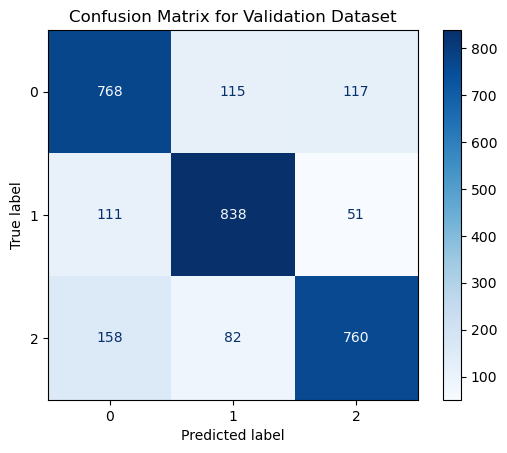

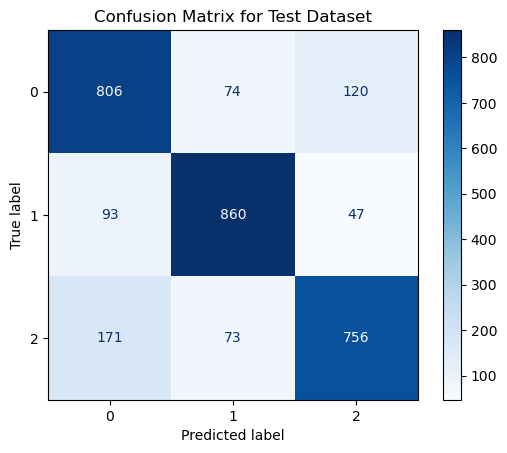

In [22]:
 
train_conf_matrix = confusion_matrix(train_labels, train_preds)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=range(num_classes))
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Dataset")
plt.show()
 
val_conf_matrix = confusion_matrix(val_labels, val_preds)
val_disp = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=range(num_classes))
val_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Validation Dataset")
plt.show()
 
test_conf_matrix = confusion_matrix(test_labels, test_preds)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=range(num_classes))
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Dataset")
plt.show()


/var/folders/yt/h8g2tq612_99wzrx5yrmx9bm0000gn/T/ipykernel_31449/2398468223.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("cnn_mod

CNN Test Accuracy: 0.8703
CNN Test F1-Score: 0.8712


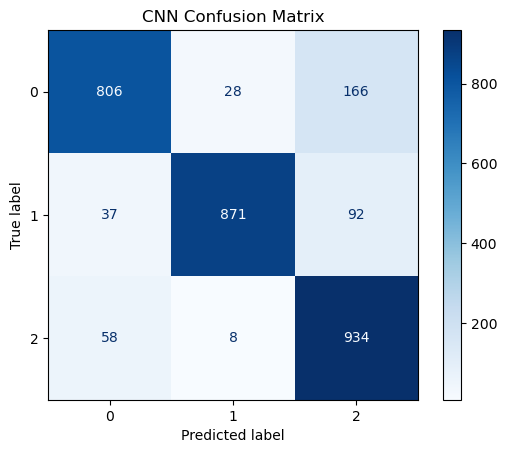

MLP Test Accuracy: 0.7937
MLP Test F1-Score: 0.7941


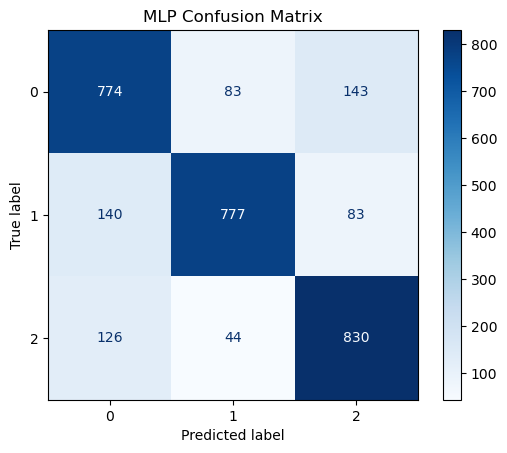

In [8]:
cnn_model = CNN(num_classes=3)   
cnn_model.load_state_dict(torch.load("cnn_model.pth")) 
cnn_model.eval()
 
mlp_model = MLP(input_size=32 * 32 * 3, num_classes=3) 
mlp_model.load_state_dict(torch.load("mlp_model.pth")) 
mlp_model.eval()
 
def evaluate_model(model, test_loader, is_cnn=True):
    test_preds, test_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if not is_cnn: 
                inputs = inputs.view(inputs.size(0), -1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_preds = np.array(test_preds)
    test_labels = np.array(test_labels)
    accuracy = accuracy_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds, average='weighted')
    conf_matrix = confusion_matrix(test_labels, test_preds)

    return accuracy, f1, conf_matrix

cnn_accuracy, cnn_f1, cnn_conf_matrix = evaluate_model(cnn_model, test_loader, is_cnn=True)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"CNN Test F1-Score: {cnn_f1:.4f}")
ConfusionMatrixDisplay(confusion_matrix=cnn_conf_matrix, display_labels=range(3)).plot(cmap=plt.cm.Blues)
plt.title("CNN Confusion Matrix")
plt.show()

mlp_accuracy, mlp_f1, mlp_conf_matrix = evaluate_model(mlp_model, test_loader, is_cnn=False)
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")
print(f"MLP Test F1-Score: {mlp_f1:.4f}")
ConfusionMatrixDisplay(confusion_matrix=mlp_conf_matrix, display_labels=range(3)).plot(cmap=plt.cm.Blues)
plt.title("MLP Confusion Matrix")
plt.show()